In [1]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import sentiwordnet as swn
import math
from math import exp, expm1, log, log10
import numpy as np
import turtle
import pandas as pd
from pycorenlp import StanfordCoreNLP
import sys, os


nlp = StanfordCoreNLP('http://localhost:9000')
dependency_parser = nlp.annotate
positive_lexicon = []
negative_lexicon = []

def read_lexicon():
    global positive_lexicon;
    global negative_lexicon;
    
    with open(os.path.join(os.path.abspath('opinion-lexicon-English/') , 'positive-words.txt'), 'r') as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
         
        positive_lexicon = file.readlines()
    
    with open(os.path.join(os.path.abspath('opinion-lexicon-English/') , 'negative-words.txt'), 'r', encoding = "ISO-8859-1") as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
        
        negative_lexicon = file.readlines()
        
    positive_lexicon = list(map(lambda word: word.rstrip("\n\r"), positive_lexicon))
    negative_lexicon = list(map(lambda word: word.rstrip("\n\r"), negative_lexicon))
    
        
read_lexicon()
op_set = positive_lexicon + negative_lexicon

negation = [
    "afraid",
    "can't",
    "cannot",
    "deny",
    "mean",
    "negate",
    "negation",
    "negative",
    "neither",
    "never",
    "no",
    "non",
    "none",
    "nor",
    "not",
    "nothing",
    "refusal",
    "refuse",
    "reject",
    "rejection"
]

In [2]:
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

def geometric_medianX(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

In [3]:
def graph(radii, theta, key, show = False):
    if show:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot([0,0],[-2,2])
        plt.plot([-2,2],[0,0])
        plt.axis([-1,1,-1,1])
    i=0
    a=[]
    b=[]
    rad=list(radii.values())
    theta1=list(theta.values())

    while(i<len(radii)):
        a.append(rad[i]*math.cos(theta1[i]))
        b.append(rad[i]*math.sin(theta1[i]))
        i+=1 
    
    if show:
        plt.scatter(a,b,label="circles",color="r",marker="o",s=10)
        q = 0
        rad2=list(radii.keys())
        for i,j in zip(a,b):
            ax.annotate('%s' %rad2[q], xy=(i,j), xytext=(15,0), textcoords='offset points')
            q = q+1    


        points = []
        for x,y in zip(a,b):
            points.append([x, y])

        if(len(points) == 0):
            points.append([0, 0])

        senti_x, senti_y = geometric_medianX(points)
        plt.scatter(senti_x,senti_y,label="circles",color="b",marker="o",s=10)
        ax.annotate('%s' % '', xy=(senti_x,senti_y), xytext=(15,0), textcoords='offset points')



        ax.add_artist(plt.Circle((0,0),1.0,color='b',fill=False))
        plt.xlabel('Sentiment Strength')
        plt.ylabel('Orientation')
        plt.title(key)
        plt.savefig("graph.png")
    
    return a, b

In [4]:
def analyse_file(key, lines):    
    radii = get_TDOC(lines, key)    
    return radii

def get_TDOC(lines, key):
    freq = {'Init': 0}              #Number of times context term occurs with key
    freq.clear()
    prohib = [''] #stopWords
    for line in lines:
        words = line.split(" ")
        if key in words:
            for context in words:
                flag=0
                for i in prohib:
                    if i == context:
                        flag=1
                        break
                if flag==0 and context!=key and context in op_set:
                    freq.setdefault(context, 0)
                    freq[context] = freq.get(context) + 1
                                           
    N = 0                           #Total Number of terms in Document
    for line in lines:
        words = line.split(" ")
        N += len(words)

    Nci = {'Init': 0}               #Total terms that occur with context term
    Nci.clear()
    for context in freq.keys():
        for line in lines:
            words = line.split(" ")
            if context in words:
                Nci.setdefault(context, 0)
                Nci[context] += len(words)

    radii = {'Init': 0}             #Get Radius of context term with TDOC formula
    radii.clear()
    
    df = pd.DataFrame(columns=['c', 'm', 'N', 'Nc', 'f', 'N/Nc', 'log(N/Nc)', 'fxlog(N/Nc)', '/4'])
    max_value = 0
    for term in freq.keys():
        radii[term] = (freq[term]*(log(N/Nci[term])))
        
        if radii[term] > max_value:
            max_value = radii[term]
        
    for term in freq.keys():
        radii[term] = radii[term]/max_value
        
        df = df.append({'c': term,
                'm': key,
                'N': N,
                'Nc': Nci[term],
                'f': freq[term],
                'N/Nc': "{0:.2f}".format(N/Nci[term]),
                'log(N/Nc)': "{0:.2f}".format(log(N/Nci[term])),
                'fxlog(N/Nc)': "{0:.2f}".format(freq[term]*(log(N/Nci[term]))),
                'normalisasi': "{0:.2f}".format((freq[term]*(log(N/Nci[term])))/max_value)
               }, ignore_index=True)
    
#     df.to_excel("tdoc.xlsx")
    return radii                    #Returns entire set of context terms related to key


In [5]:
def get_theta(key, sentences):
    scores = []
    for sentence in sentences:
        flag = True
        endscore = 0
#         if key in positive_lexicon:
#             endscore += 0.75
#         elif key in negative_lexicon:
#             endscore -= 0.75
            
#         if key == 'cramped':
#             endscore -= 0.2
#         elif key == 'unappealing':
#             endscore += 0.1
#         else:
#             endscore -= 0.2
        try:
            score = swn.senti_synset(key + '.a.1')
            if score.pos_score() > score.neg_score():
                endscore += score.pos_score()
            else:
                endscore += score.neg_score() * (-1)
        except:
            print(key)
            
#         words = sentence.split(' ')
#         word_around = []
#         for x in range(0, len(words)):
#             try:
#                 if (words[x+1] == key) or (words[x+2] == key) or (words[x+3]== key) or (words[x+4]== key):
#                     word_around.append(words[x])
#                 elif (words[x-1] == key):
#                     word_around.append(words[x])
#             except:
#                 pass

#         for neg in negation:
#             if neg in sentence:
# #                 endscore *= (-1)
#                 break

        scores.append(endscore)
            
    final_score = np.average(scores)
    return np.pi * final_score

def prior_sentiment(radii, key, all_sentences):
    theta = {'Init': 0}
    theta.clear()
    for word in radii.keys():
        sentences = []
        for sentence in all_sentences:
            words = sentence.split(' ')
            if (word in words) and (key in words):
                sentences.append(sentence)
                
        filter = get_theta(word, sentences)            #if function returns 0 word does not exist in lexicon
        theta[word] = filter
        
    return theta

def senti(key, lines, show = False):
    radii = analyse_file(key, lines)
    theta = prior_sentiment(radii, key, lines)
    a, b = graph(radii, theta, key, show)
    points = []
    for x,y in zip(a,b):
        points.append([x, y])

    if(len(points) == 0):
        points.append([0, 0])
    senti_x, senti_y = geometric_medianX(points)
#     print(theta)
    return senti_x, senti_y
#     return theta

In [6]:
import string
def rem_punct(word):
    return word.replace('  ', ' ').strip().lower().translate(str.maketrans('', '', string.punctuation))

In [7]:
import pandas as pd

def run(tipe):
    df = pd.read_csv('Results/'+ tipe +'.csv')
    sf = pd.DataFrame(columns = ['opini','sentimen'])
    
    data = []
    for sent in df['review']:
        data.append(rem_punct(sent))

    opinions_all = []
    for opinions in df['opinion']:
        if type(opinions) != float:
            opinion = opinions.split('|')
            for o in opinion:
                if o == '-' or o == '':
                    continue
                opinions_all.append(o)
    opinions_sorted = sorted(list(dict.fromkeys(opinions_all)))

    for opinion in opinions_sorted:
        sentimen = ''
#         if opinion in negative_lexicon:
#             sentimen = 'negative'
#         elif opinion in positive_lexicon:
#             sentimen = 'positive'
#         else:
        a, b = senti(opinion, data)
        if b > 0:
            sentimen = 'positive'
        else:
            sentimen = 'negative'
#         print(sentimen, '\t', opinion)
        sf = sf.append({'opini': opinion,
                        'sentimen': sentimen
                       }, ignore_index=True)
    sf.to_csv('Results/Opinion/'+ tipe + '.csv')
    sf.to_excel('Results/Opinion/'+ tipe + '.xlsx')

In [8]:
run('FOOD')
run('AMBIENCE')
run('PRICES')
run('SERVICE')

deficiencies
enjoy
deficiencies
unusually
freeze
fun
die
beautifully
delight
recommend
beautifully
delight
haze
reasonably
reasonably
recommend
consistently
outrageously
unusually
gem
generously
allergies
enjoy
unusually
variety
delight
bargain
fun
reasonably
allergies
recommend
fairly
exceeded
consistently
outrageously
fun
fairly
recommend
complaints
stinks
enjoyed
enjoyed
deficiencies
enjoyed
deficiencies
gem
allergies
haze
fun
efficiently
enjoyed
exceeded
enjoyed
fun
heaven
freeze
fairly
recommend
liberty
recommend
efficiently
gem
vent
kills
perfection
flair
recommend
perfection
delightfully
ghetto
gem
attraction
hang
hate
love
recommend
enjoy
gem
dearth
complain
fun
love
delight
miraculously
flair
delight
efficiently
vent
kills
miraculously
flair
gimmick
gem
fairly
recommend
reasonably
delight
bargain
bargain
fun
reasonably
love
recommend
love
fairly
complaint
complaint
reasonably
complaint
fairly
absurdly
work
incredibly
intimidate
dissappointed
absurdly
work
perfection
haze
enjoy

In [9]:
def beda(kata, tipe):
    df = pd.read_csv('Results/'+ tipe +'.csv')
    print(tipe)

    data = []
    for sent in df['review']:
        data.append(rem_punct(sent))
    a, b = senti(kata, data, True)

AMBIENCE
FOOD
SERVICE
PRICES


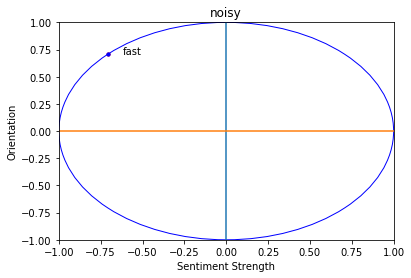

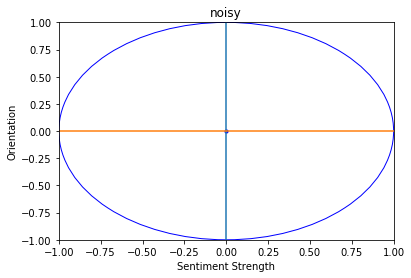

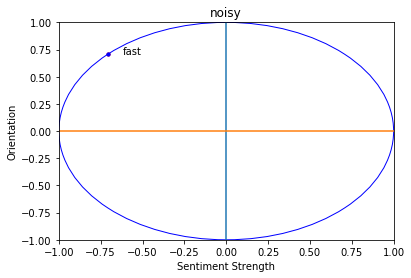

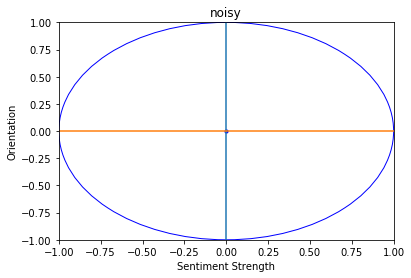

In [9]:
kata = 'noisy'
types = ['AMBIENCE', 'FOOD', 'SERVICE', 'PRICES']
for tipe in types:
    beda(kata, tipe)

In [11]:
b

0.7070955853769126

In [12]:
score = swn.senti_synset('good.a.1')

In [13]:
score.pos_score()

0.75

In [14]:
score.neg_score()

0.0

In [15]:
import random

positive = []
for i in range(0, 20):
    positive.append(negative_lexicon[random.randint(0,len(negative_lexicon))])
positive

['perish',
 'misbecoming',
 'get-rich',
 'rant',
 'hacks',
 'farcically',
 'scolding',
 'excoriate',
 'dissidents',
 'shun',
 'abominate',
 'losing',
 'indulge',
 'oversize',
 'disquietude',
 'crumpled',
 'pander',
 'gallingly',
 'back-woods',
 'ding']